# Trading Day Data Visualization

#### 1) minute chart data from finance.yahoo

In [84]:
from urllib.parse import urlencode
from datetime import datetime, timedelta
import pandas as pd
import requests
import pytz
import json

def get_minute_data(symbol, now):
    
    start = now.replace(hour=6, minute=30, second=0, microsecond=0)
    end = start.replace(hour=13, minute=0)  
    base_url = "https://l4-query.finance.yahoo.com/v7/finance/chart/{}".format(symbol)
    params = dict(
        period1=int(start.timestamp()),
        period2=int(end.timestamp()),
        interval="1m",
        indicators="quote",
        includeTimestamps="true",
        includePrePost="true",
        events="div%7Csplit%7Cearn",
        corsDomain="finance.yahoo.com"
    )
    url = "{}?{}".format(base_url, urlencode(params))
    page = requests.get(url)
    result = page.json()['chart']['result']
    if not result:
        print(page.json())

    data = result[0]
    quote = data['indicators']['quote'][0]
    times = data['timestamp']
    period = data['meta']['currentTradingPeriod']['regular']
    start, end = period['start'], period['end']
    resp_tz = pytz.timezone(data['meta']['timezone'])
    df = pd.DataFrame(quote, index=[datetime.fromtimestamp(t, tz=resp_tz).astimezone(now.tzinfo) for t in times])
    return df


la_tz = pytz.timezone('America/Los_Angeles')
now = datetime.now(tz=la_tz)
df = get_minute_data('BAC', now)
print(df[:2])
print(df[-2:])

                               close       high    low       open    volume
2017-02-09 06:30:00-08:00  22.780001  22.820000  22.75  22.770000       0.0
2017-02-09 06:31:00-08:00  22.730000  22.799999  22.73  22.790001  847933.0
                           close  high  low  open  volume
2017-02-09 11:17:00-08:00    NaN   NaN  NaN   NaN     NaN
2017-02-09 11:18:00-08:00    NaN   NaN  NaN   NaN     NaN


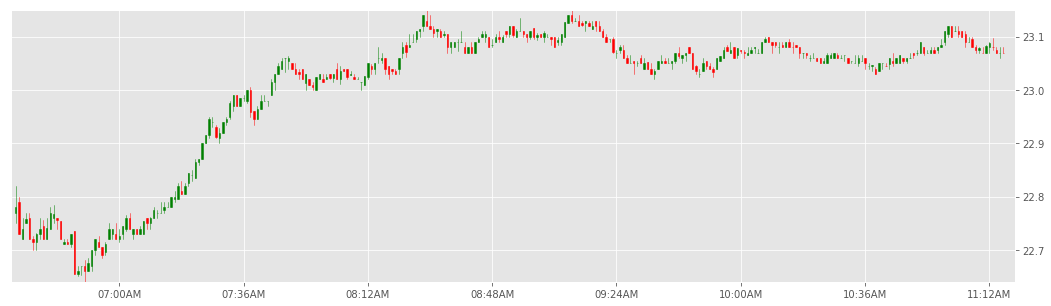

In [88]:
from matplotlib.finance import *
import matplotlib.pyplot as plt
from matplotlib import ticker, style
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY, date2num
    
style.use('ggplot')

def plot_minute_data(data):
    fig = plt.figure(figsize=(18, 5))
    ax = plt.subplot(111)
    candlestick_ochl(
        ax, 
        ((date2num(r.Index), r.open, r.close, r.high, r.low) 
         for r in data.itertuples()), 
        width=1/3600,  
        colorup='g',  
        colordown='r',
    )

    x_min, x_max = date2num(data.index.min()) - .001, date2num(data.index.max()) + .001
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(data.low.min(), data.high.max())

    minute_formatter = DateFormatter('%I:%M%p', tz=pytz.timezone('America/Los_Angeles'))
    ax.xaxis.set_major_formatter(minute_formatter)

    ax.yaxis.tick_right()
    plt.show()

plot_minute_data(df)

#### 2) the trade lot data from nasdaq.com

In [63]:
from urllib.parse import quote_plus, urlparse, parse_qs
from lxml import html, etree
import queue
import requests
import threading
import re

PROXIES = [
    '46.105.121.118:1080', '104.196.177.247:80', '158.69.187.67:8080', '172.82.144.11:3128', 
    '45.32.101.246:3128', '144.217.128.207:8080', '37.72.100.61:3128', '177.67.82.25:80', 
    '178.32.220.216:3128', '149.56.102.14:8080',  '45.55.207.152:3128', '104.224.37.5:3128', 
    '212.47.242.86:3128',  '172.82.144.10:3128','144.217.15.249:8080', '207.154.201.156:3128', 
    '138.97.241.160:3128', '40.138.64.36:8080',  '121.135.146.184:8080','104.196.249.237:80', 
    '177.54.152.155:80', '104.197.82.38:80', '96.65.123.249:8118', '104.196.229.130:80', 
    '177.67.82.12:8080', '159.203.146.38:8080', '200.199.203.177:80', '83.239.58.162:8080',  
    '204.12.155.204:3128', '149.56.233.61:8080', '125.31.19.26:80', '192.187.100.29:3128', '5.2.73.71:1080', 
    '103.243.141.43:80', '163.121.188.2:8080', '218.161.1.189:3128', '128.199.73.229:8080', 
    '163.121.188.3:8080', '186.179.109.77:8080', '138.201.63.123:31288', '96.239.193.243:8080', 
    '51.254.221.166:3128', '36.66.63.180:3128', '193.171.90.2:8080', '91.98.94.112:80', 
    '5.2.73.231:1080', '37.187.100.23:3128', '192.148.69.102:8080', '58.97.81.11:80', 
    '46.29.119.20:3128', '61.93.131.51:8998', '23.88.102.25:8080', '196.202.255.66:80', 
    '118.70.197.68:8080', '115.249.2.192:8080', '23.88.102.24:8080', '35.166.171.212:3128', 
    '95.54.76.231:8080', '203.162.234.60:58315', '178.161.149.18:3128', '52.59.57.135:8083', 
    '192.99.120.40:80', '94.154.57.5:9999', '80.241.217.251:3128', '118.165.191.45:8998', 
    '94.177.231.20:8080', '216.56.81.209:8080', '5.63.152.21:8118', '185.58.227.184:3128', 
    '185.28.193.95:8080', '83.169.229.51:8080', '217.33.216.114:8080', '62.255.116.73:8080', 
    '175.45.57.11:8080', '54.172.23.233:8083', '183.179.231.118:9999', '5.2.64.150:1080', 
    '54.153.62.91:9999', '12.33.254.195:3128', '155.94.213.135:8118', '95.170.202.110:8080', 
    '89.164.96.233:80', '153.149.166.219:3128', '49.205.246.59:8080', '5.2.75.15:1080',
    
    '89.40.121.243:80', '54.206.70.173:8083', '85.220.189.18:9090', '5.85.63.32:3128',
    '94.177.188.246:3128', '89.45.249.224:8080', '178.62.251.9:3128', '158.69.68.191:8080',
    '89.34.26.14:1080', '5.160.139.180:3128','217.150.54.177:8080', '85.220.189.21:9090', 
    '103.68.34.140:8080', '40.79.79.194:3128', '179.185.54.114:8080',
]

NUM_THREADS = 40


class ProxyFailException(Exception):
    pass    

def load_in_parrallel(*args, scrap_func, save_func):   
    
    tasks = queue.Queue() # queue with arguments for the 'get_transactions' function
    responses = queue.Queue() # queue with raw responses  
    proxies = queue.Queue()
    for p in PROXIES:
        proxies.put(p)
        
    def get_proxy():
        try:
            proxy = proxies.get_nowait()
        except queue.Empty:        
            print("Error: you have used all the proxies - this worker will stop")
        else:    
            return proxy
    
    def worker():        
        proxy = get_proxy()        
        while proxy is not None:            
            args = tasks.get()
            if args is None:
                break   
            while True:
                try:
                    scrap_func(proxy, tasks, responses, *args)
                except ProxyFailException as e:
                    proxy = get_proxy()
                    if proxy is None:
                        tasks.put(args)  # put the task back and die
                        break                    
                else:
                    break   
            tasks.task_done()
    

    threads = []
    for i in range(NUM_THREADS):
        t = threading.Thread(target=worker)
        t.start()
        threads.append(t)
        
    tasks.put(args)

    # block until all tasks are done
    tasks.join()

    # stop workers
    for i in range(NUM_THREADS):
        tasks.put(None)

    for t in threads:
        t.join()
        
    return save_func(responses)

def pull_trades(proxy, q, r, stock, pageno=None):
    base_url = "http://www.nasdaq.com/symbol/{symbol}/time-sales?time=1&pageno={pageno}"
    url = base_url.format(symbol=stock, pageno=pageno or 1)        
    try:
        page = requests.get(url, timeout=6, proxies={'http': "http://{}".format(proxy)})
    except Exception as e:
        raise ProxyFailException()
        
    else:    
        tree = html.fromstring(page.content)

        if pageno is None:
            pager = tree.find('.//ul[@id="pager"]')
            if pager is not None:
                page_links = pager.findall('.//a')
                href = page_links[-1].attrib['href']
                parsed_url = urlparse(href)
                query_params = parse_qs(parsed_url.query)
                max_page = int(query_params['pageno'][0])

                for pageno in range(1, max_page):
                    q.put((stock, pageno))
            else:
                print('Error: the pager is missing')

        table = tree.find('.//table[@id="AfterHoursPagingContents_Table"]')
        if table is None:
            raise ProxyFailException()
        else:
            for row in table:
                if row.tag == 'tr':
                    r.put(tuple(col.text_content() for col in row))
            
def save_trades(r):
    df = pd.DataFrame([], columns=('Time', 'Price', 'Volume'))
    i = 0
    while True:
        try:
            time, price, volume = r.get(block=False)
        except queue.Empty:
            break
        else:
            df.loc[i] = re.sub(r'[^\d:]+', '', time), float(re.sub(r'[^\d\.]+', '', price)), int(re.sub(r'[^\d]+', '', volume))
            i += 1
    return df

In [69]:
def get_trade_lots(symbol):    
    df = load_in_parrallel(symbol, scrap_func=pull_trades, save_func=save_trades)
    df['Cost'] = df.Price * df.Volume * 100
#     df.sort_values(by=["Time"])
    return df
    
df = get_trade_lots('BAC')
df[-5:]

Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop


,Time,Price,Volume,Cost
5395,09:50:29,22.660,100.0,226600.0
5396,09:50:28,22.660,300.0,679800.0
5397,09:50:28,22.665,1700.0,3853050.0
5398,09:50:28,22.665,700.0,1586550.0
5399,09:50:28,22.665,100.0,226650.0


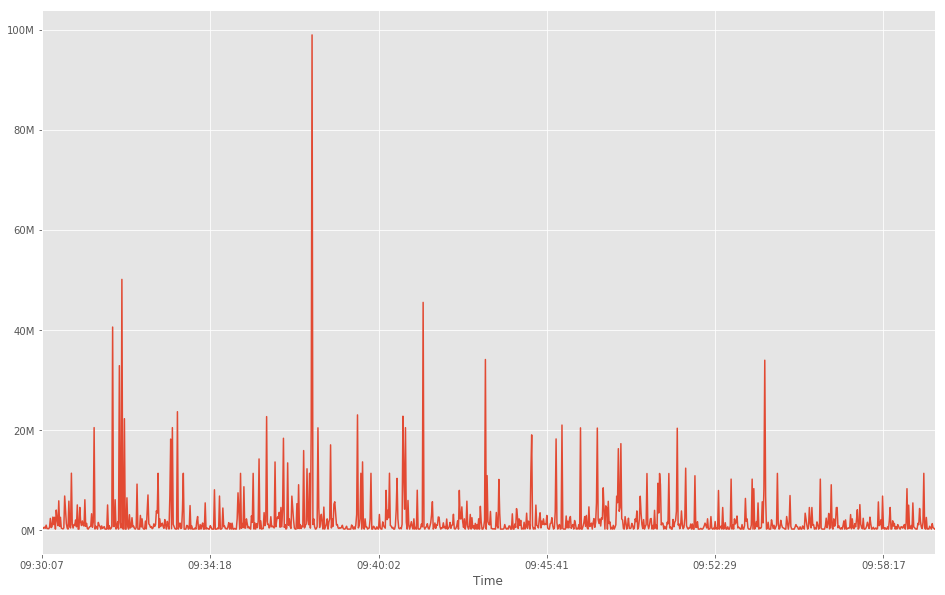

In [70]:
def plot_trade_lots(data):
#     data['Cost'] = data.Price * data.Volume * 100
    ax = data.groupby(['Time'])['Cost'].mean().plot(figsize=(16, 10))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: "%dM" % (x / 1000000)))
    plt.show()

plot_trade_lots(df)

In [73]:
# This function will display the table
from IPython.display import display, HTML



def display_trade_lots_table(data):  
    headers = ("Time", "Price", "Volume", "Cost")
    row = "<td>{}</td><td>{}</td><td>{:,.0f}</td><td>{:,.0f}</td>"
    top = data.sort_values(by=["Cost"], ascending=False)[:30]
    table_rows = (row.format(r.Time, r.Price, r.Volume, r.Cost) for r in top.itertuples()) 
    display(
        HTML(
            '<table><tr><th>{}</th></tr><tr>{}</tr></table>'.format(
                "</th><th>".join(headers),
                "</tr><tr>".join(table_rows)
            )
        )
    )  

display_trade_lots_table(df)

Time,Price,Volume,Cost
09:31:52,22.77,"100,000","227,700,000"
09:31:55,22.74,"100,000","227,400,000"
09:31:59,22.73,"100,000","227,300,000"
09:36:35,22.72,"100,000","227,200,000"
09:35:36,22.71,"63,620","144,481,020"
09:45:14,22.72,"47,800","108,601,600"
09:37:29,22.75,"43,500","98,962,500"
09:48:00,22.65,"34,266","77,612,490"
09:45:59,22.719,"30,000","68,157,000"
09:51:10,22.68,"28,659","64,998,612"


#### 3) option trades for the closest 6 strikes
    

In [66]:
def save_row(s, price, t, time, raw):
    contact = raw['contractSymbol']    
    previous_volume = transaction_volumes.get(contact)
    volume = raw['volume']
    if previous_volume is None:
        transaction_volumes[contact] = volume
    else:         
        volume_diff = volume - previous_volume
        if volume_diff > 0:            
            transaction_volumes[contact] = volume
            last_price = raw['lastPrice']
            strike = raw['strike']
            ask = raw['ask']
            bid = raw['bid']
            transaction = dict(
                stock=s,
                price=price,
                type=t,
                time=time,
                expiration=dt.fromtimestamp(raw['expiration']),
                strike=strike,
                contact=contact,
                last_price=last_price,
                bid=bid,
                ask=ask,
                volume=volume,
                open_interest=raw['openInterest'],
                implied_volatility=raw['impliedVolatility'],
                volume_diff=volume_diff,
                cost=volume_diff * 100 * last_price,
                strike_div_price=(strike / price - 1) * 100,
                last_price_position="{:.0f}".format((1 - (ask-last_price) / (ask-bid)) * 100) if ask != bid else None
            )
            return transaction

def get_transactions(stock, time):     
    url = "https://query1.finance.yahoo.com/v7/finance/options/{}".format(stock)    
    try:
        page = requests.get(url)
    except Exception as e:
        print(e)
    else:
        try:
            response = page.json()
        except Exception as e:  # network problems or wrong server answers
            print(e)
        else:
            if response['optionChain']['error']: # if any error
                print(response['optionChain']['error'])

            else:
                results = response['optionChain']['result']
                transactions = []
                for result in results:
                    price = result['quote']['regularMarketPrice']
                    for option in result['options']:
                        for call in option['calls']:
                            t = save_row(stock, price, 'Calls', time, call)
                            if t:
                                transactions.append(t)
                        for put in option['puts']:
                            t = save_row(stock, price, 'Puts', time, put)
                            if t:
                                transactions.append(t)
                return transactions

In [67]:
# This function will display the table
from IPython.display import display, HTML



def display_transations_table(data):  
    headers = (
        "Share $", "Options", "Volume", "Open Interest", "Strike", "S / S", 
        "Expiration", "Last price", "Bid", "Ask", "Position",  "Value", "Time of trade",
    )
    row = """
    <td>{price}</td><td>{type}</td><td>{volume_diff}</td><td>{open_interest}</td>
    <td>{strike}</td><td>{strike_div_price:.2f}%</td><td>{expiration:%b %d, %Y}</td>
    <td>{last_price}</td><td>{bid}</td><td>{ask}</td><td>{last_price_position}%</td>
    <td>${cost:,.0f}</td><td>{time:%I:%M%p}</td>
    """
    table_rows = (row.format(**row_data) for row_data in data) 
    display(
        HTML(
            '<table><tr><th>{}</th></tr><tr>{}</tr></table>'.format(
                "</th><th>".join(headers),
                "</tr><tr>".join(table_rows)
            )
        )
    )  

1) minute chart data from finance.yahoo


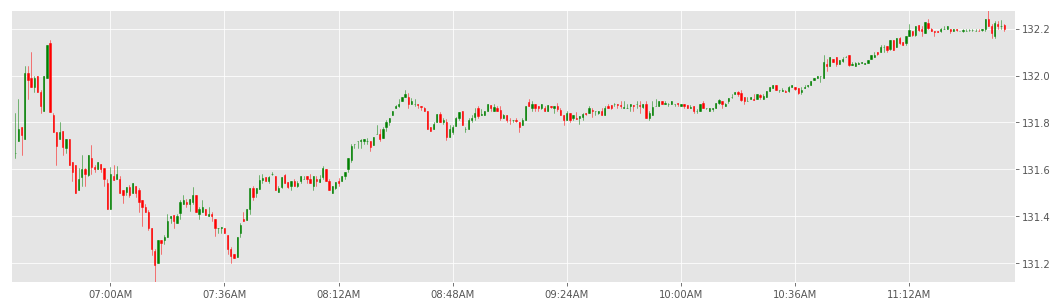

2) the trade lot data from nasdaq.com


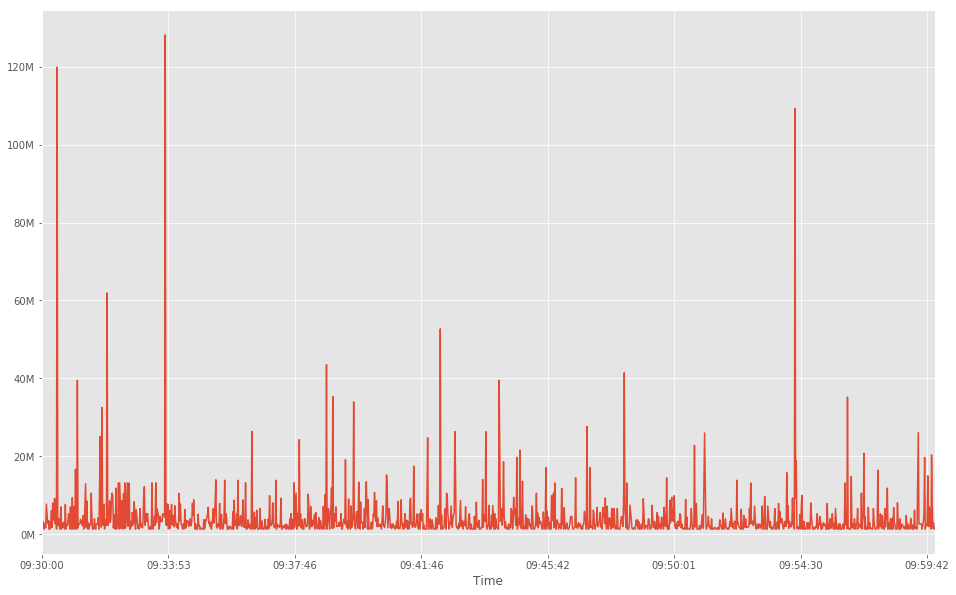

Time,Price,Volume,Cost
09:33:48,132.0,"64,120","846,384,000"
09:30:00,131.67,"23,600","310,741,200"
09:30:00,131.67,"15,147","199,440,549"
09:30:00,131.67,"15,000","197,505,000"
09:41:57,131.86,"12,251","161,541,686"
09:38:13,131.9,"11,470","151,289,300"
09:40:10,132.06,"9,930","131,135,580"
09:30:24,131.7536,"9,100","119,895,776"
09:59:14,131.47,"8,888","116,850,536"
09:30:00,131.67,"8,500","111,919,500"


3) the option transactions from finance.yahoo


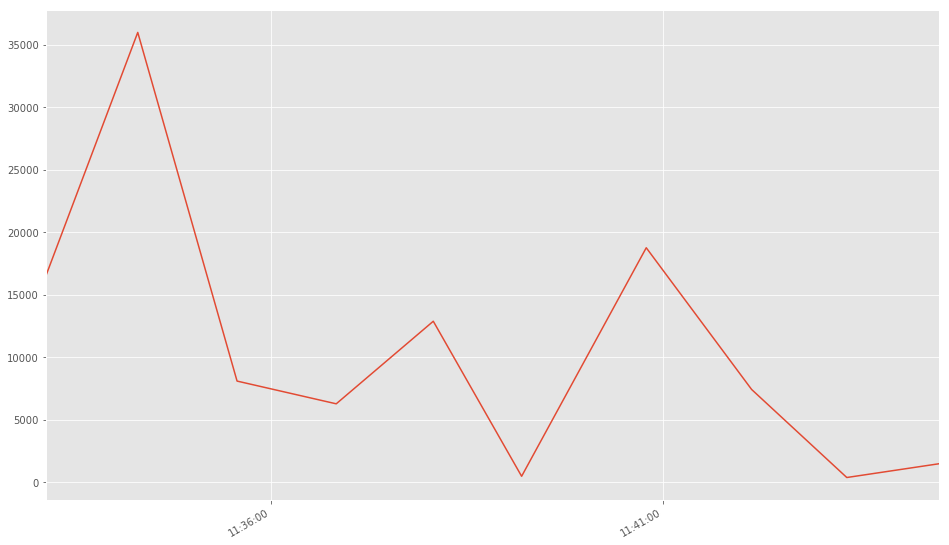

Share $,Options,Volume,Open Interest,Strike,S / S,Expiration,Last price,Bid,Ask,Position,Value,Time of trade
132.215,Calls,306,18494,132.0,-0.16%,"Feb 10, 2017",0.54,0.54,0.56,0%,"$16,524",11:40AM
132.2,Calls,265,18494,132.0,-0.15%,"Feb 10, 2017",0.58,0.58,0.59,0%,"$15,370",11:34AM
132.2,Calls,248,18494,132.0,-0.15%,"Feb 10, 2017",0.56,0.55,0.56,100%,"$13,888",11:33AM
132.17,Calls,88,6332,131.0,-0.89%,"Feb 10, 2017",1.32,1.3,1.32,100%,"$11,616",11:38AM
132.2,Calls,18,748,126.0,-4.69%,"Feb 10, 2017",6.23,6.05,6.3,72%,"$11,214",11:34AM
132.2243,Puts,200,3646,132.0,-0.17%,"Feb 10, 2017",0.37,0.37,0.38,0%,"$7,400",11:35AM
132.205,Puts,50,701,133.0,0.60%,"Feb 10, 2017",0.96,0.96,0.98,0%,"$4,800",11:42AM
132.2,Calls,36,6332,131.0,-0.91%,"Feb 10, 2017",1.33,1.31,1.34,67%,"$4,788",11:34AM
132.21,Calls,84,18494,132.0,-0.16%,"Feb 10, 2017",0.55,0.55,0.56,0%,"$4,620",11:36AM
132.2,Calls,237,17188,133.0,0.61%,"Feb 10, 2017",0.18,0.17,0.18,100%,"$4,266",11:34AM


last update 2017-02-09 11:44:30.789839-08:00
prev update 2017-02-09 11:43:20.421729-08:00
update time 0:01:18.828096
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the proxies - this worker will stop
Error: you have used all the 

In [ ]:
from datetime import datetime, timedelta
from IPython.display import clear_output
from pytz import timezone
from time import sleep
import heapq

tz = timezone('America/Los_Angeles')
STOCK_SYMBOL = 'AAPL'

last_time = None
transaction_costs = pd.Series()
largest_transactions = []
transaction_volumes = {}

while True:    
    now = datetime.now(tz=tz)
    start = now.replace(hour=6, minute=30, second=0, microsecond=0)
    stop = start.replace(hour=13, minute=0)
    
    if start <= now <= stop: # proper time for getting data
        
        if last_time: # no more often than once per minute
            diff = 60 - (now - last_time).seconds            
            if diff > 0:
                sleep(diff)  
        
        
        # GETTING DATA
        minute_data = get_minute_data(STOCK_SYMBOL, now)
        trade_lots = get_trade_lots(STOCK_SYMBOL)
        
        # transactions 
        transactions = get_transactions(STOCK_SYMBOL, now)
        if transactions:
            transaction_costs[now] = sum(t['cost'] for t in transactions) 
            largest_transactions.extend(transactions)
            largest_transactions = heapq.nlargest(30, largest_transactions, key=lambda i: i['cost'])
        
        
        ## DISPLAYING DATA
        clear_output()
        print('1) minute chart data from finance.yahoo')
        plot_minute_data(minute_data)
        
        print('2) the trade lot data from nasdaq.com')
        plot_trade_lots(trade_lots)
        display_trade_lots_table(trade_lots)
        
        print('3) the option transactions from finance.yahoo')
        if len(transaction_costs):
            transaction_costs.plot(figsize=(16, 10))
            plt.show()
        if largest_transactions:
            display_transations_table(largest_transactions)
        
        # some statistics
        print("last update", now)
        print("prev update", last_time) 
        print("update time", datetime.now(tz=tz) - now)
        last_time = now        
    else:
        largest_transactions = [] # drop transactions
        if now < start:
            diff = start - now
            print("time to start:", diff)
            
        else:
            start_tommorow = start + timedelta(days=1)
            print("start tommorow at", start_tommorow)
            diff = start_tommorow - now
        
        sleep(diff.seconds + diff.microseconds * 0.1 ** 6)